# Notebook de nettoyage
## Adrian Rodriguez
## Projet 4 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Categorisez-automatiquement-des-questions   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Les données
Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

Contraintes :
- Mettre en œuvre une approche non supervisée.
- Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
- Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
- Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
- Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

In [248]:
import pandas as pd
pd.options.display.max_columns = None

import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
plt.style.use("default")

from functions import *

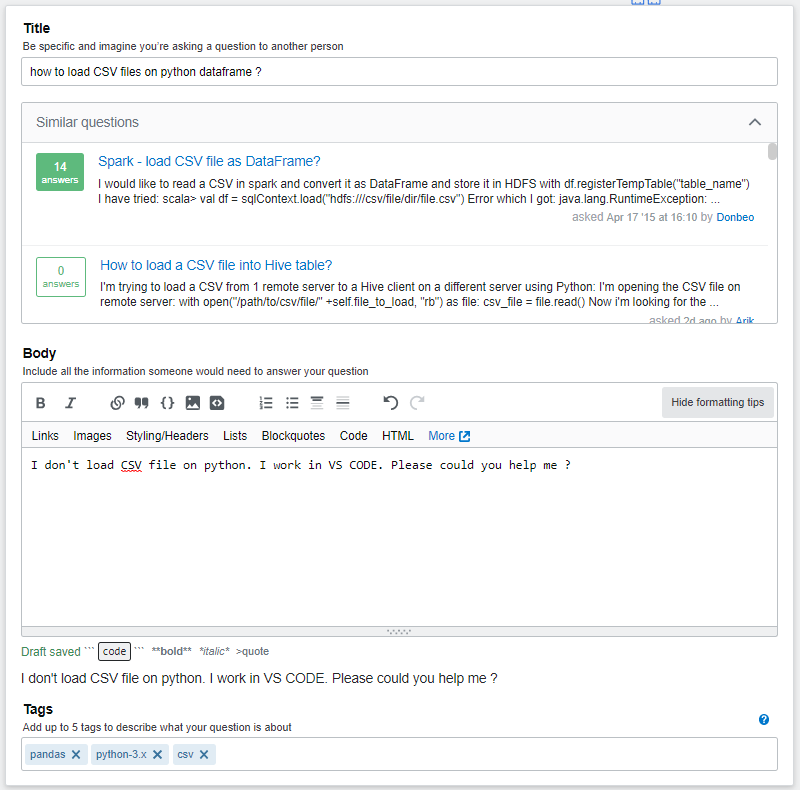

In [249]:
Image('src/post.png')

---
# 1. Importation et exploration préliminaire
Les données ont été extraite du site stackexchangeexplorer. J'ai traité des post récents.    
Requête SQL :      
SELECT TOP 1000 *    
FROM posts    
ORDER BY CreationDate DESC

Les données ont été stockées dans le fichiser 'QueryResults.csv'.

In [250]:
stack_raw = pd.read_csv('src/Posts_QueryResults.csv')

In [251]:
stack_raw.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,63433501,2,NaN,63431603.0,2020-08-16 05:35:04,NaN,0,NaN,<p>To be able to push view controller onto the...,5443937,NaN,NaN,NaN,NaN,2020-08-16 05:35:04,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 4.0
1,63433499,2,NaN,63416894.0,2020-08-16 05:35:03,NaN,0,NaN,<p>If you use <code>PairGrid</code> instead of...,1356000,NaN,NaN,NaN,NaN,2020-08-16 05:35:03,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 4.0
2,63433500,1,NaN,NaN,2020-08-16 05:35:03,NaN,0,1.0,"<p>The shape of my test_data is (418, 13).\nT...",14112861,NaN,NaN,NaN,NaN,2020-08-16 05:35:03,How to reduce the dimension of data frame?,<python><pandas><dataframe><machine-learning><...,0.0,0,NaN,NaN,NaN,CC BY-SA 4.0
3,63433498,1,NaN,NaN,2020-08-16 05:34:42,NaN,0,2.0,<p>in my views I defined the paginator functio...,13097857,NaN,NaN,NaN,NaN,2020-08-16 05:34:42,How can I fix this paginator problem in python,<python><django><post><pagination><blogs>,0.0,0,NaN,NaN,NaN,CC BY-SA 4.0
4,63433497,1,NaN,NaN,2020-08-16 05:34:42,NaN,0,2.0,<p>I am trying to dynamically add <strong>acti...,14112866,NaN,NaN,NaN,NaN,2020-08-16 05:34:42,Dynamically add active to menu using javascript,<javascript><php><html><jquery>,0.0,0,NaN,NaN,NaN,CC BY-SA 4.0


In [252]:
stack_raw.shape

(1000, 23)

In [253]:
stack_raw.columns

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense'],
      dtype='object')

In [254]:
stack_raw.isna().sum()

Id                          0
PostTypeId                  0
AcceptedAnswerId          970
ParentId                  487
CreationDate                0
DeletionDate             1000
Score                       0
ViewCount                 513
Body                        0
OwnerUserId                 0
OwnerDisplayName         1000
LastEditorUserId          799
LastEditorDisplayName    1000
LastEditDate              799
LastActivityDate            0
Title                     513
Tags                      513
AnswerCount               513
CommentCount                0
FavoriteCount             977
ClosedDate                961
CommunityOwnedDate        999
ContentLicense              0
dtype: int64

In [256]:
stack = stack_raw.copy()

# 2. Exploration préliminaire
## Identification des types de posts

In [257]:
stack.PostTypeId.value_counts()

2    513
1    487
Name: PostTypeId, dtype: int64

In [258]:
stack[stack.Tags.notna()][['PostTypeId', 'ParentId']].isna().sum()

PostTypeId      0
ParentId      487
dtype: int64

Losque l'on créé un nouveau sujet, l'utilisateur doit indiquer un titre et des tags correpondant à son sujet. Si un post ne contient ni titre, ni tags, alors il s'agit d'un post de réponse à une question.   
De ce fait, si `PostTypeId` = 1 ou si `ParentId` est manquant, alors il s'agit d'un post de question, un post où je dois suggérer des tags à l'utilisateur final.

## Activité des utilisateurs finaux du site

In [264]:

stack.CreationDate = pd.to_datetime(stack.CreationDate, format="%Y-%m-%d %H:%M:%S")
delta = stack.CreationDate.max() - stack.CreationDate.min()
delay_post = round(delta.total_seconds() / len(stack), 0)
delay_question = round(delta.total_seconds() / len(stack[stack.PostTypeId == 1]), 0)
print(f'Le site Stackoverflow recoit un post, que ce soit en question ou en réponse aux questions, toutes les {delay_post} secondes et une nouvelle question toutes les {delay_question} secondes')

Le site Stackoverflow recoit un post, que ce soit en question ou en réponse aux questions, toutes les 13.0 secondes et une nouvelle question toutes les 27.0 secondes


## Taux de réponse à une question

In [279]:
no_response = round(stack.AnswerCount.value_counts().loc[0] / len(stack) * 100, 0)
print(f'{no_response} % des questions posées ne trouvent aucune réponse')

72.0 % des questions posées ne trouvent aucune réponse


# 3. Exploration des tags associés aux questions

In [280]:
columns = ['Id', 'Title', 'Body', 'Tags']
stack = stack[stack.PostTypeId == 1][columns]
stack.head()

,Id,Title,Body,Tags
2,63433500,How to reduce the dimension of data frame?,"<p>The shape of my test_data is (418, 13).\nT...",<python><pandas><dataframe><machine-learning><...
3,63433498,How can I fix this paginator problem in python,<p>in my views I defined the paginator functio...,<python><django><post><pagination><blogs>
4,63433497,Dynamically add active to menu using javascript,<p>I am trying to dynamically add <strong>acti...,<javascript><php><html><jquery>
5,63433496,Find text between two json keys using regex,<p>I have a json text file which contains keys...,<python><python-3.x><regex><regex-greedy><re>
7,63433494,Django Rest Framework - customize default list...,<p>My models are bound with multiple fields us...,<django><django-models><django-rest-framework>


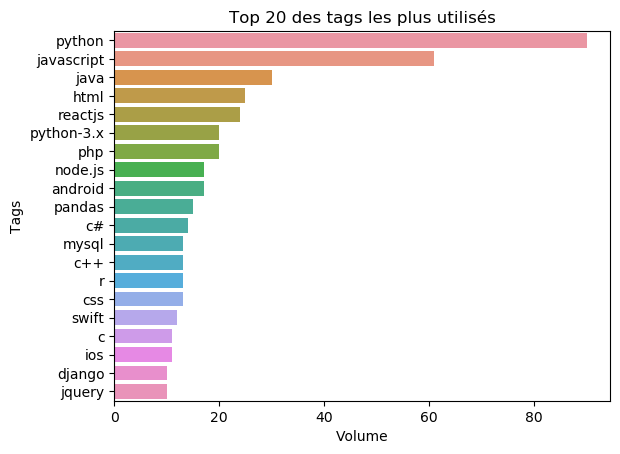

In [281]:
stack.Tags = stack.Tags.apply(lambda x: x.replace('<', '').replace('>', ' ')).str.split()
tags = stack.Tags.explode().reset_index()
tags = tags.groupby('Tags').count().sort_values(by='index', ascending=False).head(20).reset_index()

plt.clf()
sns.barplot(y='Tags',
            x='index',
            data=tags,
            orient='h')
plt.title('Top 20 des tags les plus utilisés')
plt.xlabel('Volume')
plt.ylabel('Tags')

plt.savefig('img/img_tags.png',
            transparent=True,
            bbox_inches="tight")

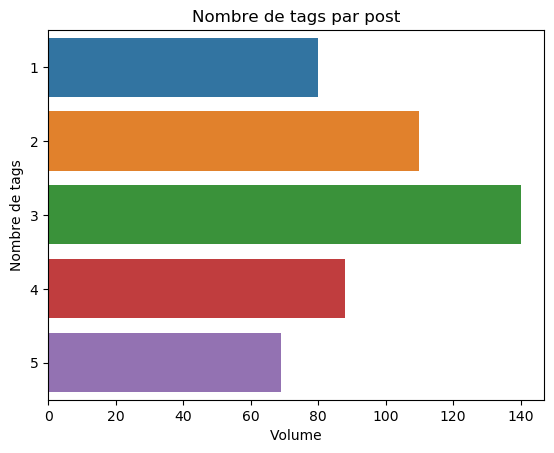

In [282]:
tags_count = stack.Tags.apply(lambda x: len(x)).reset_index()
tags_count = tags_count.groupby('Tags').count().reset_index()

plt.clf()
sns.barplot(y='Tags',
            x='index',
            data=tags_count,
            orient='h')
plt.title('Nombre de tags par post')
plt.xlabel('Volume')
plt.ylabel('Nombre de tags')

plt.savefig('img/img_tags_count.png',
            transparent=True,
            bbox_inches="tight")

# NLP Preprocessing
Les blocs de codes préformatés et blocs d'image génèrent du bruit. je dois les enlever.
J'enlève ensuite les tags HTML, les éventuels caractères accentués

In [68]:
stack['Title_Body'] = stack.Title + ' ' + stack.Body
stack

,Id,Body,Title,Tags,Title_Body
2,63433500,"<p>The shape of my test_data is (418, 13).\nT...",How to reduce the dimension of data frame?,<python><pandas><dataframe><machine-learning><...,How to reduce the dimension of data frame? <p>...
3,63433498,<p>in my views I defined the paginator functio...,How can I fix this paginator problem in python,<python><django><post><pagination><blogs>,How can I fix this paginator problem in python...
4,63433497,<p>I am trying to dynamically add <strong>acti...,Dynamically add active to menu using javascript,<javascript><php><html><jquery>,Dynamically add active to menu using javascrip...
5,63433496,<p>I have a json text file which contains keys...,Find text between two json keys using regex,<python><python-3.x><regex><regex-greedy><re>,Find text between two json keys using regex <p...
7,63433494,<p>My models are bound with multiple fields us...,Django Rest Framework - customize default list...,<django><django-models><django-rest-framework>,Django Rest Framework - customize default list...
...,...,...,...,...,...
986,63432452,<p>Hey so I'm experiencing a small error in my...,While loop iteration issue in C,<c><while-loop>,While loop iteration issue in C <p>Hey so I'm ...
987,63432451,<p>How can I get the xpath of 'img src' of the...,how to get nested scrapy - selectors,<python-3.x><scrapy>,how to get nested scrapy - selectors <p>How ca...
990,63432448,<p>I have a simple program which represents a ...,How Can I Serialize a Derived Class whose base...,<c#><.net><serialization>,How Can I Serialize a Derived Class whose base...
995,63432442,<p>I am trying to implement slash commands whi...,Can CI/CD actions be triggered by Bitbucket PR...,<continuous-integration><bitbucket><devops><bi...,Can CI/CD actions be triggered by Bitbucket PR...


In [69]:
# Je retire les bloc de code préformatté et les bloc image
stack.Title_Body = stack.Title_Body.apply(lambda x: extract_preformattext_imageurl(x))
# Je retire les tags HTML
stack.Title_Body = stack.Title_Body.apply(lambda x: strip_html_tags(x))
# Je retire les retours ligne \n
stack.Title_Body = stack.Title_Body.apply(lambda x: x.replace('\n', ''))
# Je retire les éventuels caractères accentués
stack.Title_Body = stack.Title_Body.apply(lambda x: remove_accented_chars(x))
# Je passe tous les caractères en minuscule
stack.Title_Body = stack.Title_Body.apply(lambda x: x.lower())

stack.Title_Body.head(20)

2     how to reduce the dimension of data frame?  th...
3     how can i fix this paginator problem in python...
4     dynamically add active to menu using javascrip...
5     find text between two json keys using regex  i...
7     django rest framework - customize default list...
11    can you secretly run a python file?  i couldn'...
12    the first function doesn't recognizes the new ...
15    display javascript object in webpage without k...
19    why can't i pass in a functor with a mutex to ...
20    how to use scikit-optimization for bayesian op...
27    when using on_member_join, how do i get the me...
30    assets file obj\project.assets.json doesn't ha...
31    how to post button value to label field using ...
34    how to save text using sharedpreferences on dr...
38    can anyone suggest me some beginner friendly p...
40    django cms, there is a piece of html in the in...
42    why is the time stamp not used for conflict re...
52    unable to launch jupyter notebook from a n

In [70]:
stack.Title_Body.iloc[0]

"how to reduce the dimension of data frame?  the shape of my  test_data is (418, 13).the shape of my test_scaled_data is (889, 41).  to perform the following code , how should i alter my code?  y_hat_xgb = best_clf_xgb.best_estimator_.predict(x_test_scaled).astype(int)  xgb_submisson = {'passangerid' : test_data.passengerid , 'survived':y_hat_xgb} "

In [71]:
stack['Lemma_Title_Body'] = stack.Title_Body.apply(lambda x: remove_stopwords_PRON(x))
stack

,Id,Body,Title,Tags,Title_Body,Lemma_Title_Body
2,63433500,"<p>The shape of my test_data is (418, 13).\nT...",How to reduce the dimension of data frame?,<python><pandas><dataframe><machine-learning><...,how to reduce the dimension of data frame? th...,reduce dimension datum frame shape shape perfo...
3,63433498,<p>in my views I defined the paginator functio...,How can I fix this paginator problem in python,<python><django><post><pagination><blogs>,how can i fix this paginator problem in python...,fix paginator problem python view define pagin...
4,63433497,<p>I am trying to dynamically add <strong>acti...,Dynamically add active to menu using javascript,<javascript><php><html><jquery>,dynamically add active to menu using javascrip...,dynamically add active menu use javascript try...
5,63433496,<p>I have a json text file which contains keys...,Find text between two json keys using regex,<python><python-3.x><regex><regex-greedy><re>,find text between two json keys using regex i...,find text json key use regex json text file co...
7,63433494,<p>My models are bound with multiple fields us...,Django Rest Framework - customize default list...,<django><django-models><django-rest-framework>,django rest framework - customize default list...,django rest framework customize default list v...
...,...,...,...,...,...,...
986,63432452,<p>Hey so I'm experiencing a small error in my...,While loop iteration issue in C,<c><while-loop>,while loop iteration issue in c hey so i'm ex...,loop iteration issue c hey experience small er...
987,63432451,<p>How can I get the xpath of 'img src' of the...,how to get nested scrapy - selectors,<python-3.x><scrapy>,how to get nested scrapy - selectors how can ...,nest scrapy selector xpath img src follow html
990,63432448,<p>I have a simple program which represents a ...,How Can I Serialize a Derived Class whose base...,<c#><.net><serialization>,how can i serialize a derived class whose base...,serialize derive class base serializable simpl...
995,63432442,<p>I am trying to implement slash commands whi...,Can CI/CD actions be triggered by Bitbucket PR...,<continuous-integration><bitbucket><devops><bi...,can ci/cd actions be triggered by bitbucket pr...,ci cd action trigger bitbucket pr comment try ...


In [72]:
stack['Tags'] = stack.Tags.apply(lambda x: x.replace('<', '').replace('>', ' '))
stack['Lemma_Tags'] = stack['Tags'].apply(lambda x: remove_stopwords_PRON(x))
stack

,Id,Body,Title,Tags,Title_Body,Lemma_Title_Body,Lemma_Tags
2,63433500,"<p>The shape of my test_data is (418, 13).\nT...",How to reduce the dimension of data frame?,python pandas dataframe machine-learning shapes,how to reduce the dimension of data frame? th...,reduce dimension datum frame shape shape perfo...,python pandas dataframe machine learn shape
3,63433498,<p>in my views I defined the paginator functio...,How can I fix this paginator problem in python,python django post pagination blogs,how can i fix this paginator problem in python...,fix paginator problem python view define pagin...,python django post pagination blog
4,63433497,<p>I am trying to dynamically add <strong>acti...,Dynamically add active to menu using javascript,javascript php html jquery,dynamically add active to menu using javascrip...,dynamically add active menu use javascript try...,javascript php html jquery
5,63433496,<p>I have a json text file which contains keys...,Find text between two json keys using regex,python python-3.x regex regex-greedy re,find text between two json keys using regex i...,find text json key use regex json text file co...,python regex regex greedy
7,63433494,<p>My models are bound with multiple fields us...,Django Rest Framework - customize default list...,django django-models django-rest-framework,django rest framework - customize default list...,django rest framework customize default list v...,django django model django rest framework
...,...,...,...,...,...,...,...
986,63432452,<p>Hey so I'm experiencing a small error in my...,While loop iteration issue in C,c while-loop,while loop iteration issue in c hey so i'm ex...,loop iteration issue c hey experience small er...,c loop
987,63432451,<p>How can I get the xpath of 'img src' of the...,how to get nested scrapy - selectors,python-3.x scrapy,how to get nested scrapy - selectors how can ...,nest scrapy selector xpath img src follow html,scrapy
990,63432448,<p>I have a simple program which represents a ...,How Can I Serialize a Derived Class whose base...,c# .net serialization,how can i serialize a derived class whose base...,serialize derive class base serializable simpl...,c serialization
995,63432442,<p>I am trying to implement slash commands whi...,Can CI/CD actions be triggered by Bitbucket PR...,continuous-integration bitbucket devops bitbuc...,can ci/cd actions be triggered by bitbucket pr...,ci cd action trigger bitbucket pr comment try ...,continuous integration bitbucket devop bitbuck...


In [73]:
vectorizer = CountVectorizer()

In [74]:
X_train, X_test, y_train, y_test = train_test_split(stack.Lemma_Title_Body, stack.Lemma_Tags, test_size=0.2)

In [75]:
# Generate training Bow vectors
X_train_bow = vectorizer.fit_transform(X_train)
# Generate test BoW vectors
X_test_bow = vectorizer.transform(X_test)

In [76]:
from sklearn.naive_bayes import MultinomialNB
# Create MultinomialNB object
clf = MultinomialNB()
# Train clf
clf.fit(X_train_bow, y_train)
# Compute accuracy on test set
accuracy = clf.score(X_test_bow, y_test)
print(accuracy)

0.02040816326530612
